### Load report

In [54]:
import pandas as pd
import numpy as np

class FinancialReport():
    FINANCIAL_REPORT_PATH = [
        "../database/financial_report/date/",
        "../database/financial_report/balance/",
        "../database/financial_report/bill/",
        "../database/financial_report/flow/",
    ]
    
    def __init__(self) -> None:
        pass

    def __read_sub_reports(self, ticker: str):
        self._sub_report = [pd.read_csv("{}{}.csv".format(path, ticker)) 
                            for path in FinancialReport.FINANCIAL_REPORT_PATH]
    
    def __get_first_common_element(self, l1, l2):
        for v in l1:
            if v in l2:
                return v
            
    def __get_last_common_element(self, l1, l2):
        for v in reversed(l1):
            if v in l2:
                return v
            
    def __remove_duplicate_year(self):
        full_date_publication = self._sub_report[0]["Date"].to_list()
        year_publication = [date.split("-")[0] for date in full_date_publication]
        duplicate_rows = []
        for i in range(len(year_publication)-1):
            for j in range(i+1, len(year_publication)):
                if year_publication[i] == year_publication[j]:
                    duplicate_rows.append(j)
        
        self._sub_report[0] = self._sub_report[0].drop(duplicate_rows)
        

    def __replace_data(self):
        self.__remove_duplicate_year()
        full_date_publication = self._sub_report[0]["Date"].to_list()
        year_publication = [date.split("-")[0] for date in full_date_publication]
        # Find earliest common element
        first_value = self.__get_first_common_element(year_publication, self._report.columns.to_list())
        last_value = self.__get_last_common_element(year_publication, 
                                                   self._report.columns.to_list())  
        data_range = [str(i) for i in range(int(first_value), int(last_value) + 1)]
        columns = self._report.columns.to_list()
        col_to_drop = list(set(columns).difference(data_range))
        if len(col_to_drop) > 0:
            self._report = self._report.drop(col_to_drop, axis=1)

        new_column = full_date_publication[year_publication.index(first_value):
                                           year_publication.index(last_value) + 1]

        self._report.columns = new_column

    def __concatenate_sub_reports(self):
        column_name = self._sub_report[1].iloc[0, 1:].astype("str").to_list()
        index_name = []
        for rep in self._sub_report[1:]:
            index_name += rep.iloc[1:,0].to_list() 

        report = np.vstack([rep.iloc[1:,1:].to_numpy() for rep in self._sub_report[1:]])
        self._report = pd.DataFrame(report, index=index_name, columns=column_name)

    def get_report(self, ticker: str) -> pd.DataFrame:
        self.__read_sub_reports(ticker)
        self.__concatenate_sub_reports()
        self.__replace_data()
        return self._report.transpose()

    

### Chemical sector

In [55]:
import pandas as pd

PATH_TO_COMPANY_LIST = [
    "../database/company_list/wig_chemia.csv",
    "../database/company_list/wig_odziez.csv",
    "../database/company_list/wig_spozywczy.csv",
]


company_name = pd.concat([pd.read_csv(path) for path in PATH_TO_COMPANY_LIST])
report_df = [FinancialReport().get_report(ticker) for ticker in company_name["TICKER"]]
report_corr = [df.corr().to_numpy() for df in report_df]


/tmp/ipykernel_155805/2102006455.py:5: RuntimeWarning: invalid value encountered in log10
  df = pd.DataFrame(increase_value(np.log10(report_df[0].to_numpy()[1:]), np.log10(report_df[0].to_numpy()[:-1])),


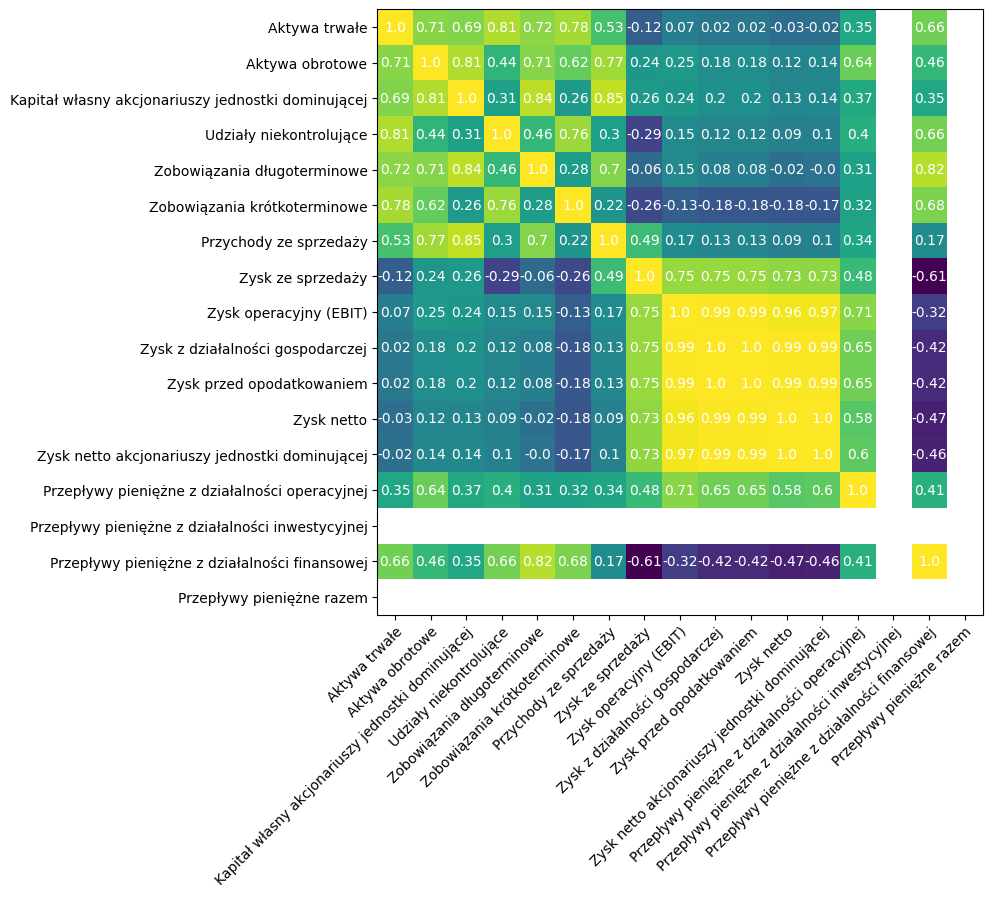

In [165]:
def increase_percent(final, initial):
    return 100 * (final - initial) / abs(initial)


df = pd.DataFrame(increase_percent(report_df[0].to_numpy()[1:], report_df[0].to_numpy()[:-1]),
                  columns = report_df[0].columns,
                  index = report_df[0].index[1:])

report_diff_percent = [pd.DataFrame(increase_percent(report.to_numpy()[1:], 
                                                     report.to_numpy()[:-1]),
                                                     columns = report_df[0].columns,
                                                     index = report_df[0].index[1:]) 
                                                     for report in report_df]


show_correlation_matrix(corr.to_numpy(), labels=corr.columns, dec=2)

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def show_correlation_matrix(corr_matrix: np.ndarray, labels: list, dec: int = 1):
    fig, ax = plt.subplots()
    im = ax.imshow(corr_matrix)

    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            text = ax.text(j, i, round(corr_matrix[i, j], dec),
                        ha="center", va="center", color="w")
            
    fig.set_size_inches(10,10)
    fig.tight_layout()
    plt.show()

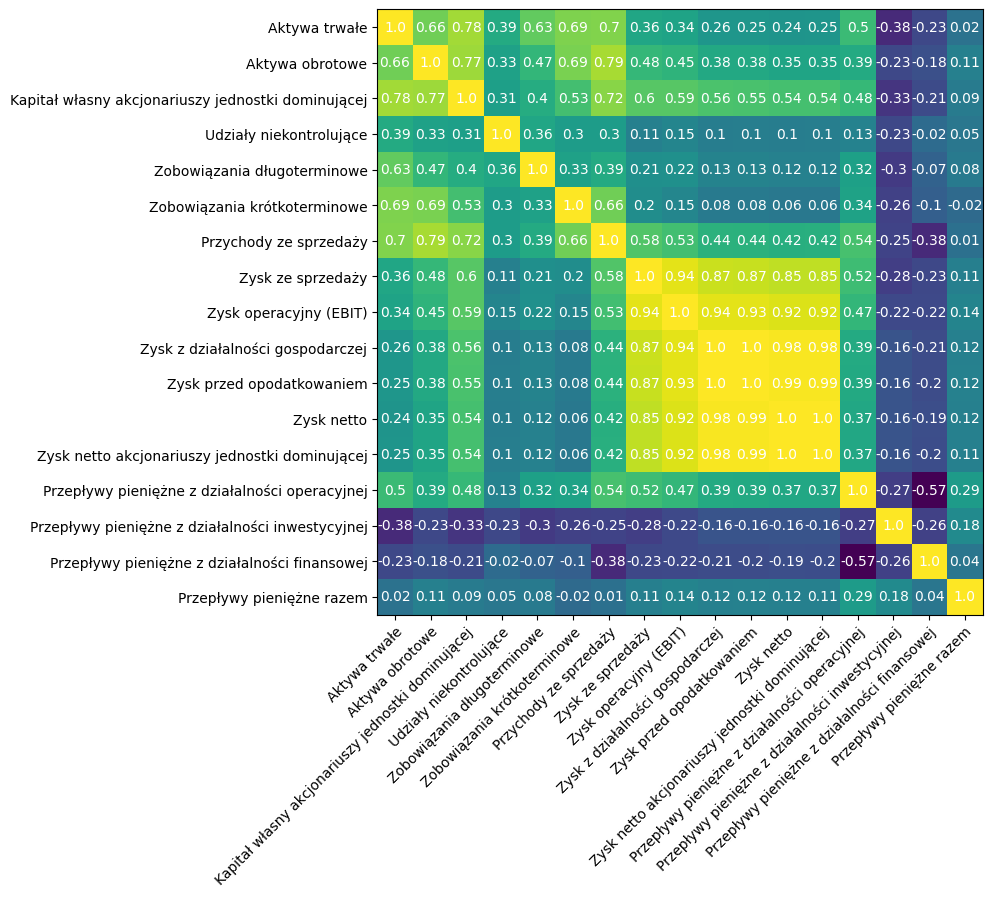

In [57]:
masked_report_corr = np.ma.masked_array(report_corr, np.isnan(report_corr))
masked_corr_matrix = np.ma.mean(masked_report_corr, axis=0)

show_correlation_matrix(masked_corr_matrix, report_df[0].columns, 2)

### List highly correlated data

Za zmienne silnie skorelowane uważamy te dla których współczynnik korelacji $>0.7$

In [58]:
highly_correlated = [
    'Kapitał własny akcjonariuszy jednostki dominującej',
    'Przychody ze sprzedaży',
    'Zysk ze sprzedaży', 
    'Zysk operacyjny (EBIT)',
    'Zysk z działalności gospodarczej', 
    'Zysk przed opodatkowaniem',
    'Zysk netto akcjonariuszy jednostki dominującej',
    ]

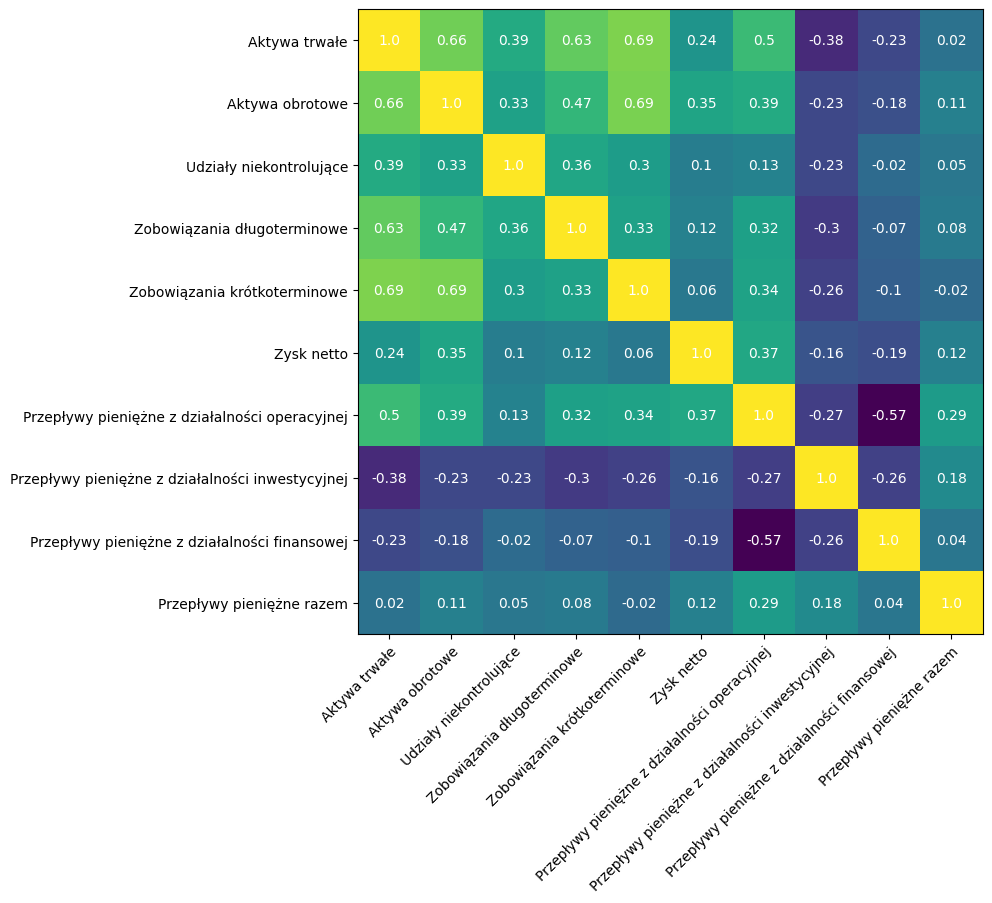

In [23]:
filtered_report_df = [report.drop(columns=highly_correlated) for report in report_df]
filtered_report_corr = [df.corr().to_numpy() for df in filtered_report_df]

masked_report_corr = np.ma.masked_array(filtered_report_corr, np.isnan(filtered_report_corr))
masked_corr_matrix = np.ma.mean(masked_report_corr, axis=0)

show_correlation_matrix(masked_corr_matrix, filtered_report_df[0].columns, 2)

In [59]:
report_df[2].mean(axis=0).to_numpy()
company_name

,TICKER,NAME
0,ATT,Grupa Azoty SA
1,PCR,PCC Rokita SA
2,PCE,Police SA
3,PWX,Polwax SA
0,CCC,CCC SA
1,CDL,CDRL SA
2,EAH,Esotiq&Henderson SA
3,HRP,Harper Hygienics SA
4,IPO,Intersport Polska SA
5,LPP,LPP SA


In [124]:
mean = np.zeros(report_df[0].shape[1])
std = np.zeros(report_df[0].shape[1])

for report in report_df:
    mean += report.mean(axis=0).to_numpy()
    std += report.std(axis=0).to_numpy()

mean = mean / len(report_df)
std = std / len(report_df)

df = report_df[0]
df = df.sub(mean)
df = df.div(std)
df

,Aktywa trwałe,Aktywa obrotowe,Kapitał własny akcjonariuszy jednostki dominującej,Udziały niekontrolujące,Zobowiązania długoterminowe,Zobowiązania krótkoterminowe,Przychody ze sprzedaży,Zysk ze sprzedaży,Zysk operacyjny (EBIT),Zysk z działalności gospodarczej,Zysk przed opodatkowaniem,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,Przepływy pieniężne z działalności operacyjnej,Przepływy pieniężne z działalności inwestycyjnej,Przepływy pieniężne z działalności finansowej,Przepływy pieniężne razem
2008-06-19,0.996801,0.549531,3.277224,-1.319928,-0.014183,-0.402932,0.531364,0.236545,0.351836,0.418719,0.416664,0.432092,0.430057,-0.496799,-3.344233,2.706061,-0.254181
2009-04-30,0.856954,0.679314,3.080777,-1.398382,-0.134173,-0.256504,0.308624,-0.803673,-0.763933,-0.532691,-0.533471,-0.424429,-0.455912,-1.143418,-1.500914,0.509985,-4.684617
2010-04-30,3.956032,2.099129,4.878435,25.441326,0.681853,1.862806,1.421605,0.694159,3.942882,3.713667,3.707196,3.994886,4.103515,-0.171920,0.346014,0.218758,0.572332
2011-03-21,6.458393,4.562616,10.616931,22.687950,2.009408,2.583599,6.987346,7.882738,5.658465,5.180884,5.172447,5.067578,4.917724,-1.902699,-2.849824,3.868781,-0.902093
2012-03-20,7.048846,5.180253,12.116266,23.403314,2.398400,2.561402,9.839190,4.230535,3.398690,3.386712,3.380680,3.061232,2.989310,2.456071,-5.848969,0.694384,-0.203631
2013-03-21,14.496270,10.828304,23.539239,41.172459,5.784743,6.184493,14.248523,1.973072,6.966254,6.872535,6.861830,7.412000,7.433540,5.195026,-6.924516,1.636143,8.801991
2014-03-21,14.847767,10.239197,24.447538,42.370833,4.726849,6.139916,14.373975,3.359645,2.649346,2.577650,2.572702,2.512273,2.262183,4.148315,-6.453366,-2.158102,-3.029442
2015-03-16,15.919945,11.668317,27.243702,44.769387,7.602764,4.830742,14.577944,9.938300,8.339682,7.939390,7.927256,7.175170,6.624869,9.117395,-16.410318,0.866352,3.599267
2016-03-11,16.950379,11.104812,28.009523,34.320118,9.004470,4.813069,12.846930,5.914568,4.631353,4.455630,4.448165,3.715130,3.554194,5.963333,-14.079912,0.911175,-2.212636
2017-04-28,17.961351,12.098231,29.489238,33.854087,10.294081,5.158281,13.918866,7.948735,5.829752,5.309525,5.300916,4.957067,4.861608,5.953639,-7.165306,0.759364,8.577382


In [26]:
def scaler(df_):

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.